# SETANDO ALTERACOES

In [24]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

import datetime
from dateutil import relativedelta

import streamlit as st

load_dotenv()

try:

    df_brasileiro_cards = pd.read_csv(os.getenv('BRASILEIRO_CARTOES'))
    df_brasileiro_full = pd.read_csv(os.getenv('BRASILEIRO_FULL')) # PARTIDAS
    df_brasileiro_stats = pd.read_csv(os.getenv('BRASILEIRO_ESTATISTICAS'))
    df_brasileiro_gols = pd.read_csv(os.getenv('BRASILEIRO_GOLS'))

except:
    raise FileExistsError('Could not find database file')

df_fla_stats = df_brasileiro_stats.query("clube == 'Flamengo'")
df_fla_gols = df_brasileiro_gols.query("clube == 'Flamengo'")
df_fla_cards = df_brasileiro_cards.query("clube == 'Flamengo'")
df_fla_jogos = df_brasileiro_full.query("mandante == 'Flamengo' or visitante == 'Flamengo'")

#PEGANDO UNIDO AS ESTATÍSTICAS COM OS JOGOS E REMOVENDO DADOS COM CAMPOS VAZIOS
df_fla_jogos = df_fla_jogos.rename(columns={'ID':'partida_id'})
df_jogos_stats = pd.merge(df_fla_jogos, df_fla_stats, how = "left", on="partida_id")


list_vencedor = []
list_result = []
list_tecnico = []

for i in df_jogos_stats.dropna().itertuples():

    if i.mandante_Placar == i.visitante_Placar:
        list_vencedor.append('Empate')
        list_result.append('Empate')
        
        if i.mandante == 'Flamengo':
            list_tecnico.append(i.tecnico_mandante)
        else:
            list_tecnico.append(i.tecnico_visitante)

    elif i.mandante_Placar > i.visitante_Placar:

        list_vencedor.append(i.mandante)

        if i.mandante == 'Flamengo':
            list_result.append('Vitoria')
        else:
            list_result.append('Derrota')

        if i.mandante == 'Flamengo':
            list_tecnico.append(i.tecnico_mandante)
        else:
            list_tecnico.append(i.tecnico_visitante)

    else:
        list_vencedor.append(i.visitante)

        if i.visitante == 'Flamengo':
            list_result.append('Vitoria')
        else:
            list_result.append('Derrota')

        if i.mandante == 'Flamengo':
            list_tecnico.append(i.tecnico_mandante)
        else:
            list_tecnico.append(i.tecnico_visitante)

df_jogos_stats = (
                    df_jogos_stats
                    .dropna()
                    .drop(['rodata_y'], axis = 1)
                    .rename(columns = {'rodata_x': 'rodata'})
                    .assign(resultado = list_result)
                    .assign(vencedor = list_vencedor)
                    .assign(tecnico = list_tecnico)
                )

# TRAZENDO OS CAMPOS DE INTERESSE
df_fla_placar = df_jogos_stats[['partida_id', 'data','mandante','visitante','tecnico_visitante', 'tecnico_mandante','mandante_Placar','visitante_Placar','resultado','vencedor','tecnico','arena','formacao_mandante', 'formacao_visitante']]

# ADICINANDO COLUNA PARA FAZER O HISTÓRICO ANUAL

df_fla_placar = (
    df_fla_placar
    .assign(ano = pd.to_datetime(df_fla_placar['data']).dt.year)
    .assign(mes = pd.to_datetime(df_fla_placar['data']).dt.month)
    .assign(mensal_overview = pd.to_datetime(df_fla_placar["data"]))
    .assign(resultado = np.where(
                                    (df_fla_placar['mandante_Placar'] > df_fla_placar['visitante_Placar']) & (df_fla_placar['mandante'] == "Flamengo"), 'Vitoria',
                                    np.where(
                                        (df_fla_placar['mandante_Placar'] > df_fla_placar['visitante_Placar']) & (df_fla_placar['mandante'] != "Flamengo"), 'Derrota',
                                    np.where(
                                        (df_fla_placar['visitante_Placar'] > df_fla_placar['mandante_Placar']) & (df_fla_placar['mandante'] == "Flamengo"), 'Derrota',
                                    np.where(
                                        (df_fla_placar['visitante_Placar'] > df_fla_placar['mandante_Placar']) & (df_fla_placar['mandante'] != "Flamengo"), 'Vitoria', 'Empate'
                                    )))))
    .assign(cont_empates = np.where(df_fla_placar['resultado'] == "Empate",1,0))
    .assign(cont_vitorias = np.where(df_fla_placar['resultado'] == "Vitoria",1,0))
    .assign(cont_derrotas = np.where(df_fla_placar['resultado'] == "Derrota",1,0))
    .assign(tecnico= np.where(df_fla_placar["mandante"] == "Flamengo", df_fla_placar["tecnico_mandante"], df_fla_placar["tecnico_visitante"]))
)

df_fla_placar["mensal_overview"] = df_fla_placar["mensal_overview"].apply(lambda x: x.replace(day = 1))

# fig, ax = plt.subplots()

# sns.set(style="dark", rc={
#     'axes.facecolor': 'gray',     # Fundo dos eixos
#     'figure.facecolor': 'black',   # Fundo da figura
#     'axes.edgecolor': 'white',     # Cor da borda dos eixos
#     'grid.color': 'gray',          # Cor da grade
#     'xtick.color': 'white',        # Cor dos ticks no eixo x
#     'ytick.color': 'white',        # Cor dos ticks no eixo y
#     'axes.labelcolor': 'white',    # Cor dos rótulos dos eixos
#     'text.color': 'white'          # Cor do texto
# })

# # sns.set(
# #     style="dark", rc = {
# #     "axes.facecolor": "black",
# #     "figure.facecolor": "black"
# #     }
# # )
# sns.lineplot(x='ano', y = 'derrotas', data = df_fla_overview_ano, ax = ax)
# # ax.set_box_aspect(aspect=0.5)
# ax.set_title('Vitorias - Ano')
df_fla_placar


C:\Users\joaop\AppData\Local\Temp\ipykernel_14168\4077376956.py:96: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .assign(ano = pd.to_datetime(df_fla_placar['data']).dt.year)
C:\Users\joaop\AppData\Local\Temp\ipykernel_14168\4077376956.py:97: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .assign(mes = pd.to_datetime(df_fla_placar['data']).dt.month)
C:\Users\joaop\AppData\Local\Temp\ipykernel_14168\4077376956.py:98: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  .assign(mensal_overview = pd.to_datetime(df_fla_placar["data"]))


,partida_id,data,mandante,visitante,tecnico_visitante,tecnico_mandante,mandante_Placar,visitante_Placar,resultado,vencedor,tecnico,arena,formacao_mandante,formacao_visitante,ano,mes,mensal_overview,cont_empates,cont_vitorias,cont_derrotas
590,6127,14/04/2018,Vitoria,Flamengo,M. Nogueira Barbieri,V. Carmo Mancini,2,2,Empate,Empate,M. Nogueira Barbieri,Barradão,4-2-3-1,4-1-4-1,2018,4,2018-04-01,1,0,0
591,6137,21/04/2018,Flamengo,America-MG,E. Alves Moreira,M. Nogueira Barbieri,2,0,Vitoria,Flamengo,M. Nogueira Barbieri,Maracanã,4-1-4-1,4-2-3-1,2018,4,2018-04-01,0,1,0
592,6148,29/04/2018,Ceara,Flamengo,M. Nogueira Barbieri,M. Oliveira Chamusca,0,3,Vitoria,Flamengo,M. Nogueira Barbieri,Arena Castelão,3-4-2-1,4-3-3,2018,4,2018-04-01,0,1,0
593,6159,06/05/2018,Flamengo,Internacional,O. Hellmann,M. Nogueira Barbieri,2,0,Vitoria,Flamengo,M. Nogueira Barbieri,Maracanã,4-1-4-1,4-1-4-1,2018,5,2018-05-01,0,1,0
594,6172,13/05/2018,Chapecoense,Flamengo,M. Nogueira Barbieri,G. Kleina,3,2,Derrota,Chapecoense,M. Nogueira Barbieri,Arena Condá,4-1-4-1,4-1-4-1,2018,5,2018-05-01,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813,8325,23/11/2023,Flamengo,Bragantino,P. Faria Caixinha,A. Bacchi,1,0,Vitoria,Flamengo,A. Bacchi,Maracanã,4-2-3-1,4-2-3-1,2023,11,2023-11-01,0,1,0
814,8371,26/11/2023,America-MG,Flamengo,A. Bacchi,D. Giacomini,0,3,Vitoria,Flamengo,A. Bacchi,Estádio Municipal Parque do Sabiá,4-2-3-1,4-2-3-1,2023,11,2023-11-01,0,1,0
815,8378,29/11/2023,Flamengo,Atletico-MG,L. Scolari,A. Bacchi,0,3,Derrota,Atletico-MG,A. Bacchi,Maracanã,4-2-3-1,4-4-2,2023,11,2023-11-01,0,0,1
816,8388,03/12/2023,Flamengo,Cuiaba,A. Cardoso de Oliveira,A. Bacchi,2,1,Vitoria,Flamengo,A. Bacchi,Maracanã,4-2-3-1,3-4-2-1,2023,12,2023-12-01,0,1,0


TypeError: only length-1 arrays can be converted to Python scalars

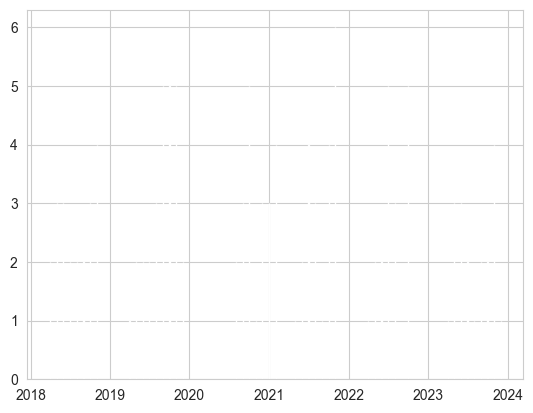

In [69]:
vitorias   = (
                df_fla_placar[['cont_vitorias','mensal_overview']]
                .groupby('mensal_overview')
                .agg('sum')
                .reset_index()
                .drop(['mensal_overview'], axis = 1)
            )

derrotas   = (
                df_fla_placar[['cont_derrotas','mensal_overview']]
                .groupby('mensal_overview')
                .agg('sum')
                .reset_index()
                .drop(['mensal_overview'], axis = 1)
            )

empates   = (
                df_fla_placar[['cont_empates','mensal_overview']]
                .groupby('mensal_overview')
                .agg('sum')
                .reset_index()
                .drop(['mensal_overview'], axis = 1)
            )

# sns.set_style("whitegrid")

categorias = df_fla_placar['mensal_overview'].drop_duplicates()

# Configurar estilo do Seaborn
sns.set_style("whitegrid")

# Definir as posições das barras (eixo X)

# Criar gráfico de barras empilhadas
plt.bar(categorias, vitorias['cont_vitorias'], label='Valor 1', color=sns.color_palette()[0])
plt.bar(categorias, derrotas, bottom=vitorias['cont_vitorias'], label='Valor 2', color=sns.color_palette()[1])
# plt.bar(categorias, empates, bottom=vitorias, label='Valor 3', color=sns.color_palette()[2])

# Adicionar legendas e títulos
plt.xlabel('Categoria')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Empilhadas')
plt.legend()

# Exibir o gráfico
plt.show()

categorias

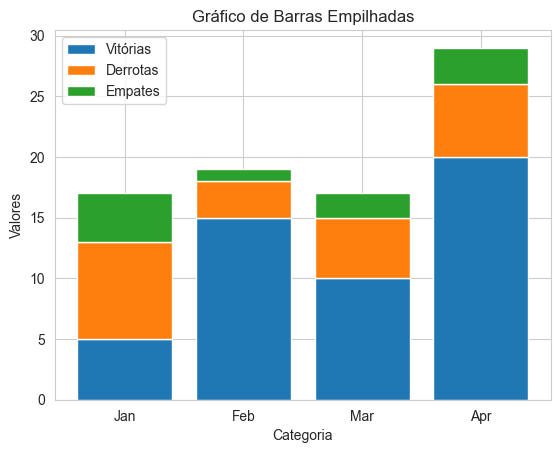

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Exemplo dos DataFrames (df_fla_placar deve ser substituído pelo seu DataFrame real)
# Apenas para fins de exemplo, substitua pelos dados reais
# df_fla_placar = pd.DataFrame({
#     'mensal_overview': ['Jan', 'Feb', 'Mar', 'Apr'],
#     'cont_vitorias': [10, 15, 20, 5],
#     'cont_derrotas': [5, 3, 6, 8],
#     'cont_empates': [2, 1, 3, 4]
# })

# Gerar agregações
vitorias = (
    df_fla_placar[['cont_vitorias', 'mensal_overview']]
    .groupby('mensal_overview')
    .agg('sum')
    .reset_index()
)

derrotas = (
    df_fla_placar[['cont_derrotas', 'mensal_overview']]
    .groupby('mensal_overview')
    .agg('sum')
    .reset_index()
)

empates = (
    df_fla_placar[['cont_empates', 'mensal_overview']]
    .groupby('mensal_overview')
    .agg('sum')
    .reset_index()
)

# Definir as categorias (eixo X)
categorias = df_fla_placar['mensal_overview'].drop_duplicates()

# Configurar estilo do Seaborn
sns.set_style("whitegrid")

# Criar gráfico de barras empilhadas
plt.bar(categorias, vitorias['cont_vitorias'], label='Vitórias', color=sns.color_palette()[0])
plt.bar(categorias, derrotas['cont_derrotas'], bottom=vitorias['cont_vitorias'], label='Derrotas', color=sns.color_palette()[1])
plt.bar(categorias, empates['cont_empates'], bottom=vitorias['cont_vitorias'] + derrotas['cont_derrotas'], label='Empates', color=sns.color_palette()[2])

# Adicionar legendas e títulos
plt.xlabel('Categoria')
plt.ylabel('Valores')
plt.title('Gráfico de Barras Empilhadas')
plt.legend()

# Exibir o gráfico
plt.show()
